In [ ]:

!pip install -q kaggle

# Move your kaggle.json file to the correct directory
!mkdir -p ~/.kaggle
!cp "/content/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
#!/bin/bash
!kaggle datasets download ejlok1/cremad


Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
 97% 439M/451M [00:04<00:00, 187MB/s]
100% 451M/451M [00:04<00:00, 117MB/s]


In [ ]:
!unzip cremad.zip -d crema_dataset

Streaming output truncated to the last 5000 lines.
  inflating: crema_dataset/AudioWAV/1031_DFA_DIS_XX.wav  
  inflating: crema_dataset/AudioWAV/1031_DFA_FEA_XX.wav  
  inflating: crema_dataset/AudioWAV/1031_DFA_HAP_XX.wav  
  inflating: crema_dataset/AudioWAV/1031_DFA_NEU_XX.wav  
  inflating: crema_dataset/AudioWAV/1031_DFA_SAD_XX.wav  
  inflating: crema_dataset/AudioWAV/1031_IEO_ANG_HI.wav  
  inflating: crema_dataset/AudioWAV/1031_IEO_ANG_LO.wav  
  inflating: crema_dataset/AudioWAV/1031_IEO_ANG_MD.wav  
  inflating: crema_dataset/AudioWAV/1031_IEO_DIS_HI.wav  
  inflating: crema_dataset/AudioWAV/1031_IEO_DIS_LO.wav  
  inflating: crema_dataset/AudioWAV/1031_IEO_DIS_MD.wav  
  inflating: crema_dataset/AudioWAV/1031_IEO_FEA_HI.wav  
  inflating: crema_dataset/AudioWAV/1031_IEO_FEA_LO.wav  
  inflating: crema_dataset/AudioWAV/1031_IEO_FEA_MD.wav  
  inflating: crema_dataset/AudioWAV/1031_IEO_HAP_HI.wav  
  inflating: crema_dataset/AudioWAV/1031_IEO_HAP_LO.wav  
  inflating: crema_da

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Dataset

In [ ]:
Crema = "/content/crema_dataset"

In [ ]:
import os
import pandas as pd

# Define the Crema directory
Crema = "/content/crema_dataset/AudioWAV/"

# List files in the directory
crema_directory_list = os.listdir(Crema)

# Initialize lists
file_emotion = []
file_path = []

for file in crema_directory_list:
    # Construct full file path
    full_path = os.path.join(Crema, file)
    file_path.append(full_path)

    # Extract emotions from the filename
    part = file.split('_')
    if len(part) > 2:  # Ensure the filename has at least 3 parts
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
    else:
        file_emotion.append('Unknown')

# Create DataFrames
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine DataFrames
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Preview the DataFrame
print(Crema_df.head())


  Emotions                                               Path
0  disgust  /content/crema_dataset/AudioWAV/1074_IWW_DIS_X...
1  disgust  /content/crema_dataset/AudioWAV/1090_MTI_DIS_X...
2    happy  /content/crema_dataset/AudioWAV/1046_IEO_HAP_L...
3     fear  /content/crema_dataset/AudioWAV/1032_IWW_FEA_X...
4  disgust  /content/crema_dataset/AudioWAV/1084_IEO_DIS_L...


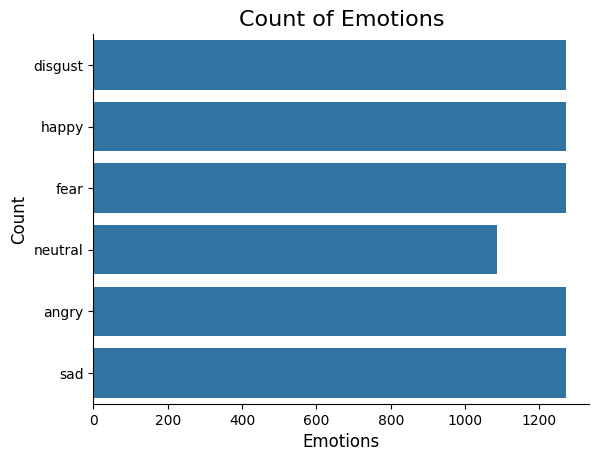

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Visualization

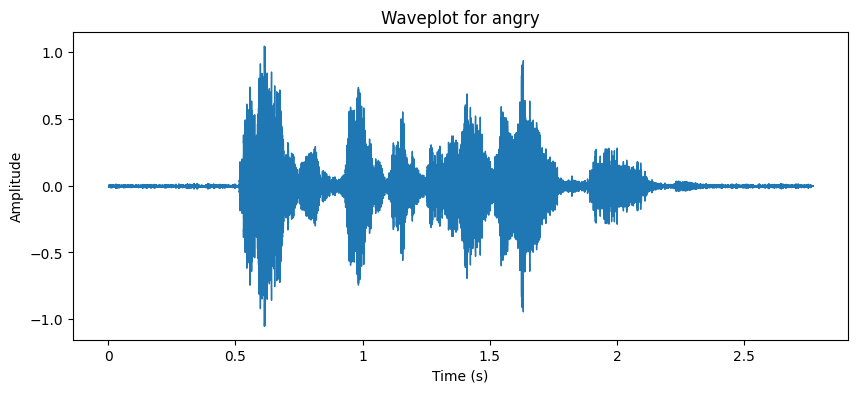

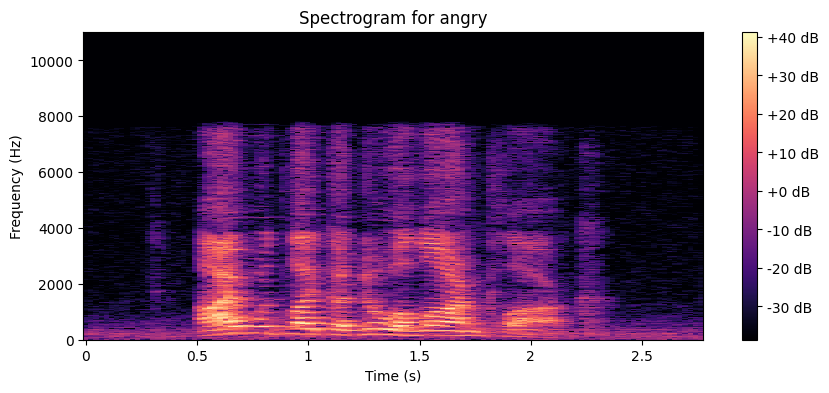

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define the helper functions
def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(f"Waveplot for {emotion}")
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def create_spectrogram(data, sampling_rate, emotion):
    stft = librosa.stft(data)
    spectrogram = librosa.amplitude_to_db(abs(stft))
    plt.figure(figsize=(10, 4))
    plt.title(f"Spectrogram for {emotion}")
    librosa.display.specshow(spectrogram, sr=sampling_rate, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

# Select emotion and path
emotion = 'angry'
filtered_paths = Crema_df.Path[Crema_df.Emotions == emotion]

# Check if any file matches the emotion
if not filtered_paths.empty:
    path = np.array(filtered_paths)[0]  # Select the first matching file
    # Load audio data
    data, sampling_rate = librosa.load(path)

    # Generate visualizations
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)

    # Play audio
    Audio(path)
else:
    print(f"No files found for emotion: {emotion}")


# MFCC Extraction

In [ ]:
labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
Crema_df.replace({'Emotions':labels},inplace=True)

<ipython-input-9-5372901cec1b>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Crema_df.replace({'Emotions':labels},inplace=True)


In [ ]:
# import librosa
# import numpy as np

# # Parameters
# num_mfcc = 13
# n_fft = 2048
# hop_length = 512
# SAMPLE_RATE = 22050

# # Data dictionary
# data = {
#     "labels": [],
#     "mfcc": []
# }

# # Loop through files
# for i in range(len(Crema_df)):
#     try:
#         # Append label
#         data['labels'].append(Crema_df.iloc[i, 0])

#         # Validate file path
#         if not os.path.exists(Crema_df.iloc[i, 1]):
#             print(f"File not found: {Crema_df.iloc[i, 1]}")
#             continue

#         # Load audio
#         signal, sample_rate = librosa.load(Crema_df.iloc[i, 1], sr=SAMPLE_RATE, duration=5.0)  # Limit to 5 seconds
#         signal = librosa.util.normalize(signal)

#         # Extract MFCCs
#         mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
#         mfcc = mfcc.T  # Transpose for frame-wise MFCCs
#         data["mfcc"].append(np.asarray(mfcc))
#     except Exception as e:
#         print(f"Error processing file {Crema_df.iloc[i, 1]}: {e}")
#         continue

#     # Print progress
#     if i % 500 == 0:
#         print(f"Processed {i} files")


Processed 0 files
Processed 500 files
Processed 1000 files
Processed 1500 files
Processed 2000 files
Processed 2500 files
Processed 3000 files
Processed 3500 files
Processed 4000 files
Processed 4500 files
Processed 5000 files
Processed 5500 files
Processed 6000 files
Processed 6500 files
Processed 7000 files


In [ ]:
import librosa
import numpy as np
import os

# Parameters
num_mfcc = 13
n_fft = 2048
hop_length = 512
SAMPLE_RATE = 22050
max_length = 300  # Fixed number of frames for padding or truncation

# Data dictionary
data = {
    "labels": [],
    "mfcc": []
}

# Function to pad or truncate MFCC arrays
def pad_or_truncate(mfcc, max_length):
    if mfcc.shape[0] > max_length:
        return mfcc[:max_length, :]
    elif mfcc.shape[0] < max_length:
        padding = np.zeros((max_length - mfcc.shape[0], mfcc.shape[1]))
        return np.vstack((mfcc, padding))
    else:
        return mfcc

# Loop through files
for i in range(len(Crema_df)):
    try:
        # Append label
        data['labels'].append(Crema_df.iloc[i, 0])

        # Validate file path
        if not os.path.exists(Crema_df.iloc[i, 1]):
            print(f"File not found: {Crema_df.iloc[i, 1]}")
            continue

        # Load audio
        signal, sample_rate = librosa.load(Crema_df.iloc[i, 1], sr=SAMPLE_RATE, duration=5.0)  # Limit to 5 seconds
        signal = librosa.util.normalize(signal)

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

        # Compute Delta (first-order derivative)
        delta = librosa.feature.delta(mfcc)

        # Compute Delta-Delta (second-order derivative)
        delta_delta = librosa.feature.delta(mfcc, order=2)

        # Combine MFCC, Delta, and Delta-Delta features
        combined_features = np.vstack((mfcc, delta, delta_delta)).T  # Combine and transpose

        # Pad or truncate to fixed length
        padded_features = pad_or_truncate(combined_features, max_length)

        # Append to data
        data["mfcc"].append(padded_features)
    except Exception as e:
        print(f"Error processing file {Crema_df.iloc[i, 1]}: {e}")
        continue

    # Print progress
    if i % 500 == 0:
        print(f"Processed {i} files")

# Convert to numpy arrays
X = np.asarray(data['mfcc'])  # Shape: (num_samples, max_length, num_features)
y = np.asarray(data['labels'])  # Shape: (num_samples,)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Processed 0 files
Processed 500 files
Processed 1000 files
Processed 1500 files
Processed 2000 files
Processed 2500 files
Processed 3000 files
Processed 3500 files
Processed 4000 files
Processed 4500 files
Processed 5000 files
Processed 5500 files
Processed 6000 files
Processed 6500 files
Processed 7000 files
Feature matrix shape: (7442, 300, 39)
Labels shape: (7442,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(5357, 300, 39) (5357,) (1340, 300, 39) (1340,) (745, 300, 39) (745,)


# Model

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dropout, Dense, GlobalAveragePooling1D, Attention, Concatenate
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D

def build_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM layers
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm_out = Dropout(0.3)(lstm_out)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out)

    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])  # Self-attention: query = value = lstm_out
    context_vector = Concatenate()([attention, lstm_out])  # Combine attention output with LSTM output

    # Global average pooling across time dimension
    pooled_output = GlobalAveragePooling1D()(context_vector)

    # Fully connected layers
    dense = Dense(64, activation='relu')(pooled_output)
    dense = Dropout(0.3)(dense)

    # Output layer
    outputs = Dense(6, activation='softmax')(dense)

    # Define the model
    model = Model(inputs, outputs)

    return model


In [ ]:
input_shape = (300, 39)  # Example: 300 timesteps, 39 features (MFCC + delta + delta-delta)
model = build_model(input_shape)
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300, 39)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 300, 256)       │        172,032 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 300, 256)       │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 300, 128)       │        164,352 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 300, 128)       │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 300, 128)       │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 300, 256)       │              0 │ attention[0][0],       │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ concatenate[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         16,448 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 6)              │            390 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 353,222 (1.35 MB)

 Trainable params: 353,222 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.3258 - loss: 1.5989 - val_accuracy: 0.4052 - val_loss: 1.4487
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.4079 - loss: 1.4416 - val_accuracy: 0.4507 - val_loss: 1.3850
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.4631 - loss: 1.3469 - val_accuracy: 0.4948 - val_loss: 1.2703
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5090 - loss: 1.2473 - val_accuracy: 0.4993 - val_loss: 1.2701
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.5325 - loss: 1.2056 - val_accuracy: 0.5410 - val_loss: 1.2037
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.5590 - loss: 1.1489 - val_accuracy: 0.5112 - val_loss: 1.2329
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5687 - loss: 1.1141 - val_accuracy: 0.5530 - val_loss: 1.1755
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.6010 - loss: 1.0598 - val

# Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.6161074042320251


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
              precision    recall  f1-score   support

     disgust       0.71      0.57      0.63       135
       happy       0.60      0.51      0.55       135
         sad       0.54      0.61      0.58       111
     neutral       0.59      0.75      0.66       110
        fear       0.61      0.48      0.54       124
       angry       0.64      0.80      0.71       130

    accuracy                           0.62       745
   macro avg       0.62      0.62      0.61       745
weighted avg       0.62      0.62      0.61       745



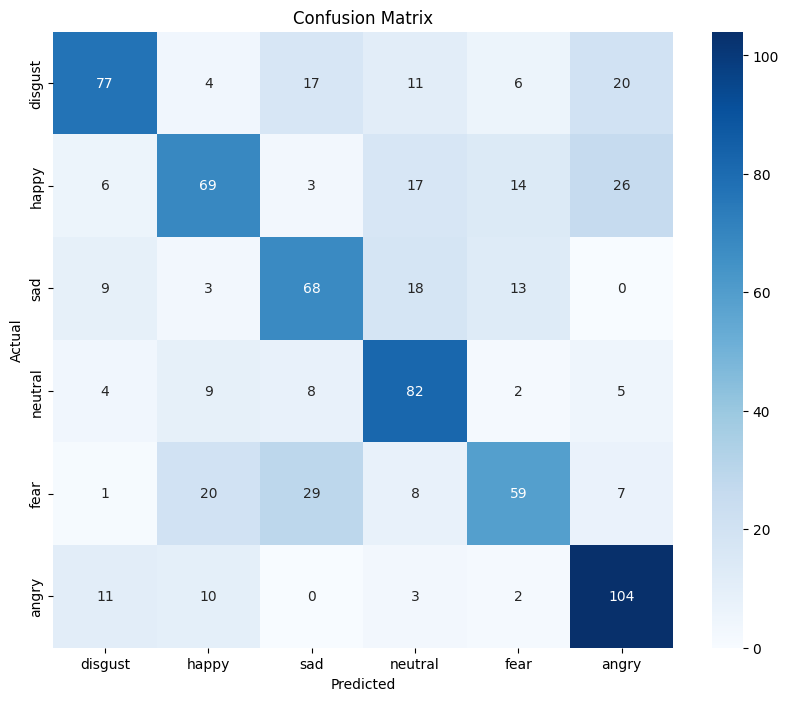

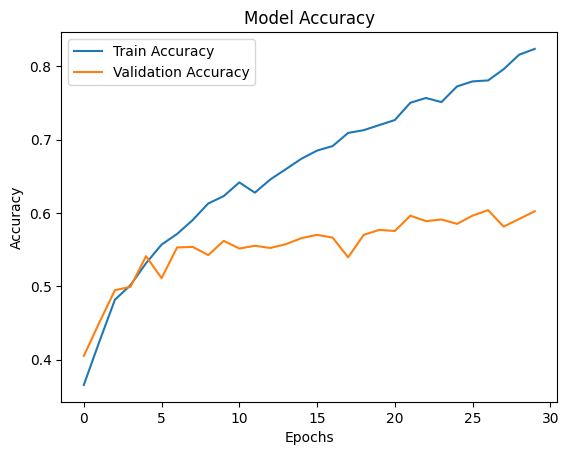

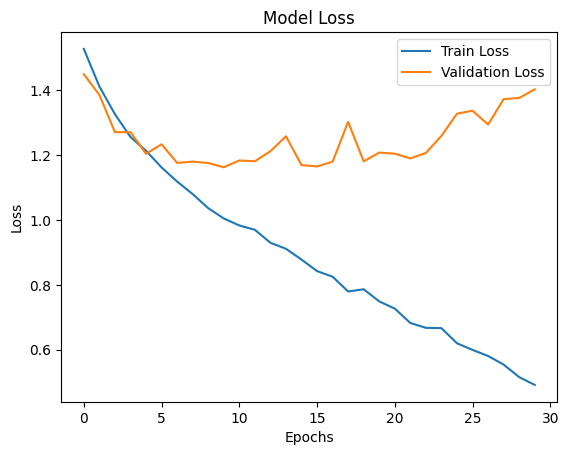

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Classification report
print(classification_report(y_test, y_pred, target_names=labels.keys()))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Training curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [ ]:
model.save('Speech-Emotion-Recognition-Model.h5')

##multi-head attention

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, GlobalAveragePooling1D, Flatten, Attention, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_experiment_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Bidirectional LSTM layers
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out)

    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])  # Self-attention: query = value = lstm_out
    context_vector = Concatenate()([attention, lstm_out])  # Combine attention output with LSTM output

    # Global average pooling across time dimension
    pooled_output = GlobalAveragePooling1D()(context_vector)

    # Fully connected layers
    dense = Dense(64, activation='relu')(pooled_output)
    dense = Dropout(0.3)(dense)

    # Output layer
    outputs = Dense(6, activation='softmax')(dense)

    # Define the model
    model = Model(inputs, outputs)

    return model

# Specify input shape
input_shape = (300, 39)  # Example: 300 timesteps, 39 features (MFCC + delta + delta-delta)

# Build and compile the model
model = build_experiment_model(input_shape)
optimiser = Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ", test_acc)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 300, 39)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 300, 64)        │          7,552 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 300, 64)        │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 150, 64)        │              0 │ batch_normalization[0… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 150, 128)       │         24,704 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 150, 128)       │            512 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 75, 128)        │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 75, 256)        │        263,168 │ max_pooling1d_1[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 75, 256)        │              0 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 75, 128)        │        164,352 │ dropout_8[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 75, 128)        │              0 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 75, 128)        │              0 │ dropout_9[0][0],       │
│                           │                        │                │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 75, 256)        │              0 │ attention_1[0][0],     │
│ (Concatenate)             │                        │                │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 256)            │              0 │ concatenate_1[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)      

 Total params: 477,382 (1.82 MB)

 Trainable params: 476,998 (1.82 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.3569 - loss: 1.5679 - val_accuracy: 0.4433 - val_loss: 1.3888
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4663 - loss: 1.3526 - val_accuracy: 0.4993 - val_loss: 1.2950
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4955 - loss: 1.2735 - val_accuracy: 0.4784 - val_loss: 1.3284
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5464 - loss: 1.1823 - val_accuracy: 0.5201 - val_loss: 1.3021
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5797 - loss: 1.1173 - val_accuracy: 0.3716 - val_loss: 1.6635
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6162 - loss: 1.0356 - val_accuracy: 0.5478 - val_loss: 1.2248
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6322 - loss: 0.9604 - val_accuracy: 0.5463 - val_loss: 1.2769
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6604 - loss: 0.9135 - val_acc

In [ ]:
model.save('Speech-Emotion-Recognition-Model.h5')